In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
import scanpy as sc


# Load and clean data

In [2]:
# pdac_a_indrop = pd.read_csv('data/pdac/GSE111672/suppl/GSE111672_PDAC-A-indrop-filtered-expMat.txt', sep='\t', index_col=0)
# pdac_b_indrop = pd.read_csv('data/pdac/GSE111672/suppl/GSE111672_PDAC-B-indrop-filtered-expMat.txt', sep='\t', index_col=0)
PDAC_DIR = "./data/pdac"
SERIES_ACCESSION = "GSE111672"
DATA_DIR = os.path.join(PDAC_DIR, SERIES_ACCESSION)
SC_DIR = os.path.join(DATA_DIR, "suppl")

pdac_a_indrop = sc.read_csv(os.path.join(SC_DIR, "GSE111672_PDAC-A-indrop-filtered-expMat.txt"), delimiter="\t").T
pdac_a_indrop.X = csr_matrix(pdac_a_indrop.X)
pdac_a_indrop.obs["cell_subclass"] = pdac_a_indrop.obs_names.to_series().astype("category")
pdac_a_indrop.obs_names_make_unique(join=".")
pdac_a_indrop.var_names_make_unique(join=".")
pdac_a_indrop = pdac_a_indrop[:, ~pdac_a_indrop.var_names.str.contains("-Mar")]


pdac_b_indrop = sc.read_csv(os.path.join(SC_DIR, "GSE111672_PDAC-B-indrop-filtered-expMat.txt"), delimiter="\t").T
pdac_b_indrop.X = csr_matrix(pdac_b_indrop.X)
pdac_b_indrop.obs["cell_subclass"] = pdac_b_indrop.obs_names.to_series().astype("category")
pdac_b_indrop.obs_names_make_unique(join=".")
pdac_b_indrop.var_names_make_unique(join=".")
pdac_b_indrop = pdac_b_indrop[:, ~pdac_b_indrop.var_names.str.contains("-Mar")]



/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
ST_DIR = os.path.join(DATA_DIR, "st")

# pdac_a_st = pd.read_csv(os.path.join(ST_DIR, "GSM3036911/GSM3036911_PDAC-A-ST1-filtered.txt"), sep='\t', index_col=0)
# pdac_b_st = pd.read_csv(os.path.join(ST_DIR, "GSM3405534_PDAC-B-ST1-filtered.txt"), sep='\t', index_col=0)
pdac_a_st = sc.read_csv(os.path.join(ST_DIR, "GSM3036911/GSM3036911_PDAC-A-ST1-filtered.txt"), delimiter='\t').T
pdac_b_st = sc.read_csv(os.path.join(ST_DIR, "GSM3405534/GSM3405534_PDAC-B-ST1-filtered.txt"), delimiter='\t').T
pdac_a_st.X = csr_matrix(pdac_a_st.X)
pdac_b_st.X = csr_matrix(pdac_b_st.X)
pdac_a_st = pdac_a_st[:, ~pdac_a_st.var_names.str.endswith("-Mar")]
pdac_b_st = pdac_b_st[:, ~pdac_b_st.var_names.str.endswith("-Mar")]

/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# normalize_cpm = lambda x: np.log1p(x * 1e6 / x.sum())
# pdac_a_st = pdac_a_st.apply(normalize_cpm, axis=0)
# pdac_b_st = pdac_b_st.apply(normalize_cpm, axis=0)


## Get coordinates for ST

In [5]:
pdac_a_st.obs = pdac_a_st.obs_names.to_series().str.split("x", expand=True).astype(int)
pdac_a_st.obs.columns = ["x", "y"]

pdac_b_st.obs = pdac_b_st.obs_names.to_series().str.split("x", expand=True).astype(int)
pdac_b_st.obs.columns = ["x", "y"]


In [6]:
# pdac_b_st.obs = pdac_b_st.columns.to_series().str.split("x", expand=True).astype(int)
pdac_a_st.obs["cell_subclass"] = pd.array([None] * pdac_a_st.shape[0], dtype="Int64")
pdac_b_st.obs["cell_subclass"] = pd.array([None] * pdac_b_st.shape[0], dtype="Int64")
# pdac_a_st.obs["cell_subclass"].dtype

# Annotate ST

In [7]:
cluster_assignments = [
    "Cancer region",
    "Pancreatic tissue",
    "Interstitium",
    "Duct epithelium",
    "Stroma",
]
cluster_to_ordinal = {c: i for i, c in enumerate(cluster_assignments)}
cluster_to_rgb = {
    "Cancer region": "#686868",
    "Pancreatic tissue": "#7670b0",
    "Interstitium": "#8dccc2",
    "Duct epithelium": "#e42a89",
    "Stroma": "#169c78",
}
pd.Series(cluster_to_ordinal)

Cancer region        0
Pancreatic tissue    1
Interstitium         2
Duct epithelium      3
Stroma               4
dtype: int64

In [8]:
pdac_a_st.obs.loc["10x10", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x13", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x14", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x15", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x16", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x17", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x19", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x20", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x24", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x25", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x26", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x27", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x28", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x29", "cell_subclass"] = 4
pdac_a_st.obs.loc["10x30", "cell_subclass"] = 3
pdac_a_st.obs.loc["10x31", "cell_subclass"] = 4
pdac_a_st.obs.loc["10x32", "cell_subclass"] = 4
pdac_a_st.obs.loc["10x33", "cell_subclass"] = 3


In [9]:

pdac_a_st.obs.loc["11x11", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x13", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x14", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x15", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x16", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x17", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x19", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x21", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x22", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x23", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x24", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x25", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x26", "cell_subclass"] = 4
pdac_a_st.obs.loc["11x27", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x28", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x29", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x30", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x31", "cell_subclass"] = 3
pdac_a_st.obs.loc["11x32", "cell_subclass"] = 4
pdac_a_st.obs.loc["11x33", "cell_subclass"] = 0
pdac_a_st.obs.loc["11x34", "cell_subclass"] = 0


In [10]:
col_no = 12
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 4


In [11]:
col_no = 13
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [12]:
col_no = 14
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1
# pdac_a_st.obs.iloc[0:20]


In [13]:
col_no = 15
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [14]:
col_no = 16
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [15]:
col_no = 17
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1



In [16]:
col_no = 18
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [17]:
col_no = 19
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [18]:
col_no = 20
pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [19]:
col_no = 21
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [20]:
col_no = 22
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [21]:
col_no = 23
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [22]:
col_no = 24
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [23]:
col_no = 25
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [24]:
col_no = 26
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 1
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [25]:
col_no = 27
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [26]:
col_no = 28
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [27]:
col_no = 29
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [28]:
col_no = 30
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 4
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 1
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 1


In [29]:
col_no = 9
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3


In [30]:
col_no = 8
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3


In [31]:
col_no = 7
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3


In [32]:
col_no = 6
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 3


In [33]:
col_no = 5
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 4


In [34]:
col_no = 4
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 4
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 4


In [35]:
col_no = 3
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

# pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 4



In [36]:
col_no = 2
# pdac_a_st.obs.loc[f"{col_no}x34", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x33", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x32", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x31", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x30", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x29", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x28", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x27", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x26", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x25", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x24", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x23", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x22", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_a_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
pdac_a_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 3
pdac_a_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 3

# pdac_a_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 3
# pdac_a_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 4



Cancer region        0
Pancreatic tissue    1
Interstitium         2
Duct epithelium      3
Stroma               4
dtype: int64

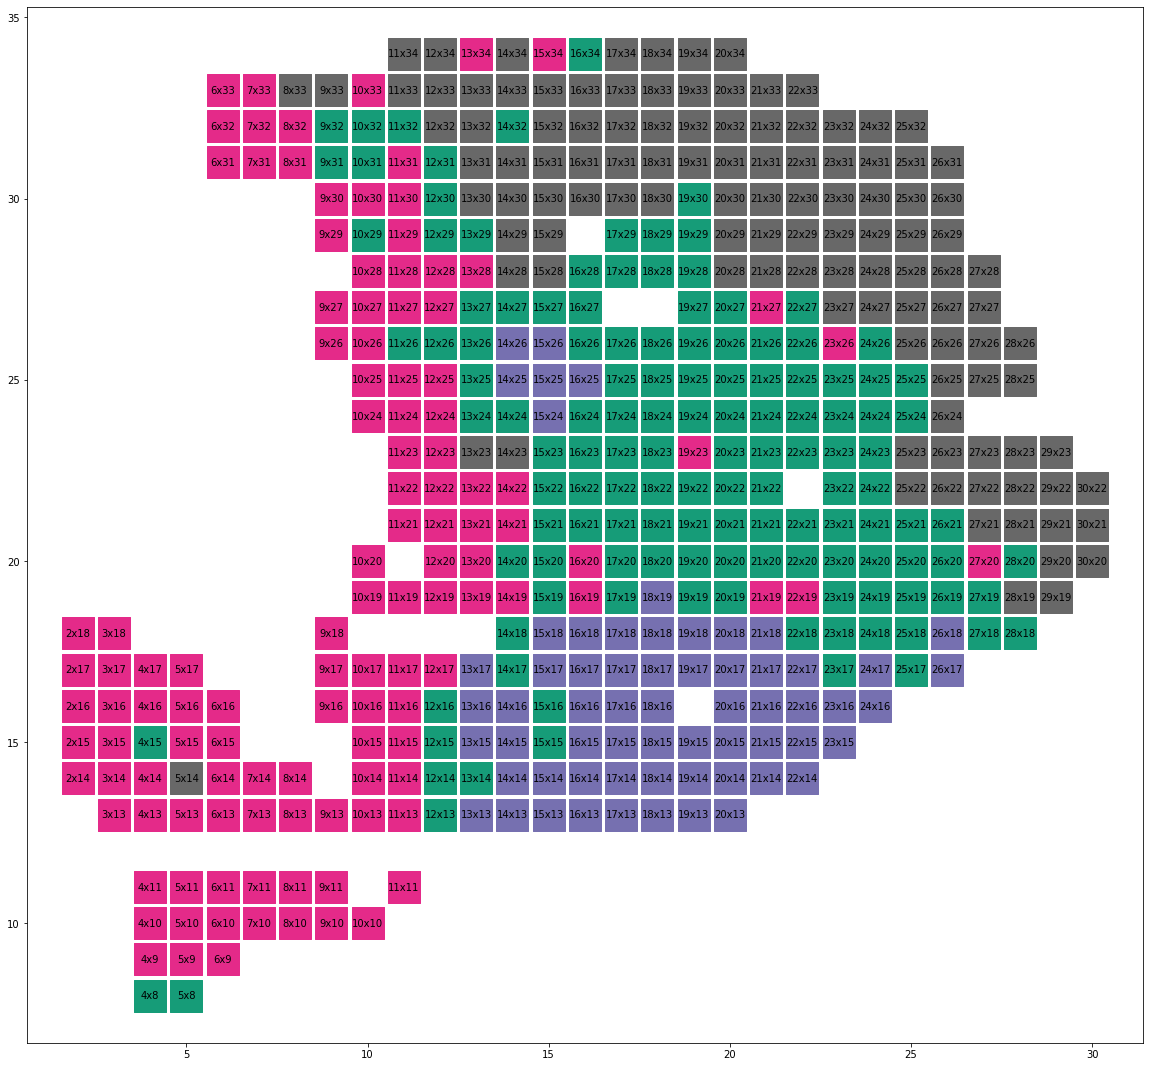

In [37]:

fig, axs = plt.subplots(1,1, figsize=(20, 20))
for col_name, coords in pdac_a_st.obs.iterrows():
    if not pd.isna(coords["cell_subclass"]):
        spot_colour = cluster_to_rgb[cluster_assignments[coords["cell_subclass"]]]
        facecolor = spot_colour
    else:
        spot_colour = "k"
        facecolor = "none"
    axs.scatter(coords[0], coords[1], marker="s", s=1000,facecolors=facecolor, edgecolors=spot_colour)
    axs.text(coords[0], coords[1], col_name, ha="center", va="center")
    axs.set_aspect("equal")
pd.Series(cluster_to_ordinal)

In [38]:
col_no = 15
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3


In [39]:
col_no = 16

pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0

pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3


In [40]:
col_no = 17

pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3


In [41]:
col_no = 18

pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3

In [42]:
col_no = 19
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3

In [43]:
col_no = 20
pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
# pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [44]:
col_no = 21
pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [45]:
col_no = 22
pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [46]:
col_no = 23
pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3


In [47]:
col_no = 24
pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [48]:
col_no = 25
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [49]:
col_no = 26
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [50]:
col_no = 27
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [51]:
col_no = 28
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [52]:
col_no = 29
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [53]:
col_no = 30
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
# pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [54]:
col_no = 31
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
# pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

In [55]:
col_no = 32
# pdac_b_st.obs.loc[f"{col_no}x21", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x20", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x19", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x18", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x17", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x16", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x15", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x14", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x13", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x12", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x11", "cell_subclass"] = 0
# pdac_b_st.obs.loc[f"{col_no}x10", "cell_subclass"] = 0
pdac_b_st.obs.loc[f"{col_no}x9", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x8", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x7", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x6", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x5", "cell_subclass"] = 2
pdac_b_st.obs.loc[f"{col_no}x4", "cell_subclass"] = 2
# pdac_b_st.obs.loc[f"{col_no}x3", "cell_subclass"] = 3
# pdac_b_st.obs.loc[f"{col_no}x2", "cell_subclass"] = 3

Cancer region        0
Pancreatic tissue    1
Interstitium         2
Duct epithelium      3
Stroma               4
dtype: int64

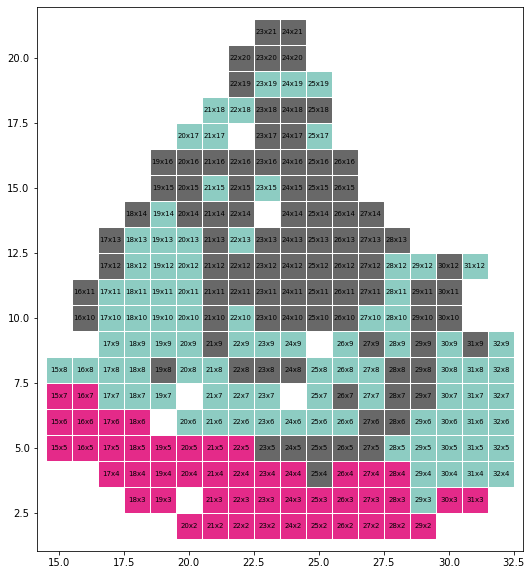

In [56]:
fig, axs = plt.subplots(1,1, figsize=(10, 10))
for col_name, coords in pdac_b_st.obs.iterrows():
    if not pd.isna(coords["cell_subclass"]):
        spot_colour = cluster_to_rgb[cluster_assignments[coords["cell_subclass"]]]
        facecolor = spot_colour
    else:
        spot_colour = "k"
        facecolor = "none"
    axs.scatter(coords[0], coords[1], marker="s", s=600,facecolors=facecolor, edgecolors=spot_colour)
    axs.text(coords[0], coords[1], col_name, ha="center", va="center", fontsize=7)
axs.set_aspect("equal")
pd.Series(cluster_to_ordinal)

# Save

In [57]:


SC_OUT_DIR = os.path.join(DATA_DIR, "sc")
ST_OUT_DIR = os.path.join(DATA_DIR, "st")

if not os.path.isdir(SC_OUT_DIR):
    os.makedirs(SC_OUT_DIR)
if not os.path.isdir(ST_OUT_DIR):
    os.makedirs(ST_OUT_DIR)

pdac_a_indrop.write(os.path.join(SC_OUT_DIR, "pdac_a_indrop.h5ad"))
pdac_b_indrop.write(os.path.join(SC_OUT_DIR, "pdac_b_indrop.h5ad"))
pdac_a_st.write(os.path.join(ST_OUT_DIR, "pdac_a_st.h5ad"))
pdac_b_st.write(os.path.join(ST_OUT_DIR, "pdac_b_st.h5ad"))

# pdac_a_indrop.write(os.path.join(SC_OUT_DIR, "pdac_a_indrop.h5ad"), compression="gzip")
# pdac_b_indrop.write(os.path.join(SC_OUT_DIR, "pdac_b_indrop.h5ad"), compression="gzip")
# pdac_a_st.write(os.path.join(ST_OUT_DIR, "pdac_a_st.h5ad"), compression="gzip")
# pdac_b_st.write(os.path.join(ST_OUT_DIR, "pdac_b_st.h5ad"), compression="gzip")

with open(os.path.join(ST_OUT_DIR, "cluster_to_ordinal.json"), "wb") as f:
    pickle.dump(cluster_to_ordinal, f)
with open(os.path.join(ST_OUT_DIR, "cluster_to_rgb.json"), "wb") as f:
    pickle.dump(cluster_to_rgb, f)